# Nystrom Method Coding

### Resources

###### Nystrom

* Scikit-Learn Implementation - [Github](https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/kernel_approximation.py#L367)

###### Randomized SVD (rSVD)

* Numpy svd Implementation - [Docs](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.svd.html)
* Scikit-Learn rSVD Implementation - [Github](https://github.com/scikit-learn/scikit-learn/blob/a24c8b464d094d2c468a16ea9f8bf8d42d949f84/sklearn/utils/extmath.py#L228)
* Facebook PCA/rSVD Implementation - [Webpage](https://research.fb.com/fast-randomized-svd/) | [Docs](http://fbpca.readthedocs.io/en/latest/) | [Github](https://github.com/facebook/fbpca/blob/master/fbpca.py#L1393)

###### Papers

* Using The Nystrom Method to Speed Up Kernel Machines - [paper](https://papers.nips.cc/paper/1866-using-the-nystrom-method-to-speed-up-kernel-machines.pdf)
* 

###### Research

* Nystrom + rSVD - [Paper](http://www.cs.cmu.edu/~muli/file/nystrom_icml10.pdf) | [Github](https://github.com/mli/nystrom)
    + Nystrom - [Github](https://github.com/mli/nystrom/blob/master/nys.m)
    + rSVD - [Github](https://github.com/mli/nystrom/blob/master/rsvd.m)
    + Nystrom + rSVD - [Github](https://github.com/mli/nystrom/blob/master/rnys.m)
* Locally Linear Landmarks - [Webpage](https://eng.ucmerced.edu/people/vladymyrov/) | [Paper](http://www.ecmlpkdd2013.org/wp-content/uploads/2013/07/131.pdf)
* Variational Nystrom Method - [Webpage](https://eng.ucmerced.edu/people/vladymyrov/)

In [1]:
from sklearn.datasets import make_swiss_roll
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
import fbpca

from scipy.spatial.distance import pdist
from scipy.linalg import cholesky
import numpy as np
import time as time

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
%matplotlib inline

In [2]:
# make some sample data
n_samples = 1500
noise = 0.01

X, y = make_swiss_roll(n_samples, noise)

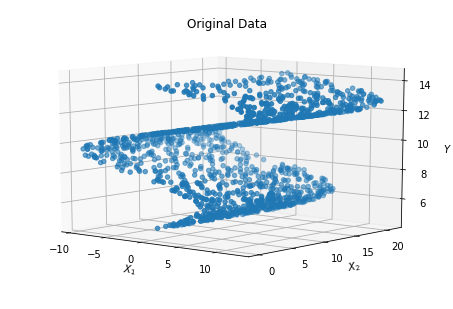

In [3]:
# plot the original data
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(10, -50)
ax.scatter(X[:,0], X[:,1], y)
plt.title('Original Data')
ax.set_xlabel(r'$X_1$')
ax.set_ylabel(r'$X_2$')
ax.set_zlabel(r'$Y$')
plt.show()

In [4]:
# construct kernel matrix
gamma = 1 / (2 * np.mean(pdist(X, metric='euclidean')))
K = rbf_kernel(X, gamma=gamma)

print('Construct RBF matrix.')
print('Size of K: {}'.format(K.shape))

Construct RBF matrix.
Size of K: (1500, 1500)


## Rank-K Nystrom Approximation to PSD matrix A

We are looking to perform an approximation of matrix $K$ such that:

$$K \approx U \times D \times U$$

#### Parameters

* err = approximation error from the frobenius norm
* $n$ is the number if components (rank-k approximation) to be used in the approximation
* $m$ samples $m$ columns of matrix $K$
* idx can specify which columns to take indices of
* random state for the random components chosen

#### Checks

* $K$ should be square and symmetric
* Default $m$ should equal $k$.
* The $m \geq k$

#### SVD Terminology and Notation

The full **Singular Value Decomposition**:

$$A = U \Sigma V^T,$$

where $A \in \mathcal{R}^{m \times n}$

---
The **Singular Values** of $A$:

$\Sigma \in \mathcal{R}^{m \times n}$ where 

* $\Sigma = \text{diag}\left( \sigma_1, \sigma_2, \ldots, \sigma_{\rho} \right)$
* $\rho=(m,n)$
* $\sigma_1 \geq \sigma_2 \geq \ldots \geq \sigma_{\rho} \geq 0$

---
The **Singular Vectors** of $A$:

$$U \in \mathcal{R}^{m \times m}, U^{T}U=I_m$$
$$V \in \mathcal{R}^{n \times n}, V^T V=I_n$$

---

The Best rank-k approximation of $A$:

$$A_k = U_k \Sigma_k V_k^T = \sum_{i=1}^{i=k} \rho_i U^{i} (V^{i})^{T}$$

---

The **Pseudo-Inverse** of $A$:

$$A^{\dagger} = V \Sigma^{-1} U^{T}$$  

---

---

##### Nystrom Approximation

\begin{align}
K \approx \tilde{K} &= \tilde{U} \tilde{D} \tilde{U} \\
&= \left( \sqrt{\frac{m}{n}} C U_w \Sigma_{w}^{-1} \right) \left( \frac{n}{m} \Sigma_w \right)\left( \sqrt{\frac{m}{n}} C U_w \Sigma_{w}^{-1} \right)^{T} \\
&= C W_{r}^{\dagger} C^{T}
\end{align}

##### Nystrom Woodbury Approximation

Using the Matrix Inversion Lemma:

\begin{align}
\left( \lambda I + K\right)^{-1} &\approx \left(\lambda I + \tilde{K} \right)^{-1} \\
&= \left( \lambda I + C W_k^{\dagger} C^{T}  \right)^{-1} \\
&= \frac{1}{\lambda} \left( I - C \left[ \lambda I + W_k^{\dagger}C^{T}C \right]^{-1} W_{k}^{-1}C^{T} \right) 
\end{align}

##### Applications

* Kernel Ridge Regression (KRR) / Gaussian Process Regression (GPR)
* Gaussian Process Classification (GPC)
* Support Vector Machines (SVMs)
* Kernel Logistic Regression
* Spectral Clustering
* Manifold Learning

### Nystrom Approximnation of K (samples, samples)

In [5]:
# Nystrom approximation of K
eps = 1e-12 # lowest error approximation

# size of K
n_samples, _ = K.shape
col_components = int(np.floor(n_samples/4))
rank_components = int(np.floor(n_samples/6))

print('Size of K: {}'.format(K.shape))
print('Number of Samples: {}'.format(n_samples))
print('Number of Components: {}'.format(rank_components))



# perform sampling (uniform sampling without replacement)

indices = np.random.permutation(n_samples)

# column indices
col_indices = indices[:col_components]
C = K[:, col_indices]                            
W = C[col_indices, :]                          # m-by-m intersection matrix

# Perform the truncated SVD
print('\nPerform Normal SVD...\n')
U, D, V = np.linalg.svd(W, full_matrices=False)

print('Shape of U: {}'.format(U.shape))
print('Shape of S: {}'.format(D.shape))
print('Shape of V: {}'.format(V.shape))

# Perform the randomized SVD
print('\nPerform FB RSVD...\n')
U_rand, D_rand, V_rand = fbpca.pca(W, k=rank_components, raw=True)

print('Shape of U rand: {}'.format(U_rand.shape))
print('Shape of S rand: {}'.format(D_rand.shape))
print('Shape of V rand: {}'.format(V_rand.shape))

Size of K: (1500, 1500)
Number of Samples: 1500
Number of Components: 250

Perform Normal SVD...

Shape of U: (375, 375)
Shape of S: (375,)
Shape of V: (375, 375)

Perform FB RSVD...

Shape of U rand: (375, 250)
Shape of S rand: (250,)
Shape of V rand: (250, 375)


In [12]:
print('Time Experiment for normal SVD.')
%time _, _, _ = np.linalg.svd(W, full_matrices=True)

print('\nTime Experiment for randomized SVD (fb).')
%time _, _, _ = fbpca.pca(W, k=rank_components, raw=True, n_iter=2)

Time Experiment for normal SVD.
CPU times: user 76 ms, sys: 0 ns, total: 76 ms
Wall time: 19.4 ms

Time Experiment for randomized SVD (fb).
CPU times: user 84 ms, sys: 0 ns, total: 84 ms
Wall time: 22.1 ms


In [13]:
# perform the approximation (Regular)
U_approx = np.sqrt(col_components / n_samples) * C @ U @ np.diag(D**(-1))
D_approx = (n_samples / col_components) * np.diag(D)

print('Size of U approximated: {}'.format(U_approx.shape))
print('Size of D approximated: {}'.format(D_approx.shape))

# perform the approximation (randomized)
U_rapprox = np.sqrt(col_components / n_samples) * C  @ U_rand
D_rapprox = (n_samples / col_components) * np.diag(D_rand**(-1))

print('Size of U rand approximated: {}'.format(U_rapprox.shape))
print('Size of D rand approximated: {}'.format(D_rapprox.shape))

Size of U approximated: (1500, 375)
Size of D approximated: (375, 375)
Size of U rand approximated: (1500, 250)
Size of D rand approximated: (250, 250)


In [ ]:
W_r = U @ np.diag(D) @ U.T
W_rand = U_rand @ np.diag(D_rand) @ U_rand.T

K_approx = U_approx @ D_approx @ U_approx.T
K_rapprox = U_rapprox @ D_rapprox @ U_rapprox.T

err = np.linalg.norm(K - K_approx, 'fro')
rerr = np.linalg.norm(K - K_rapprox, 'fro')
print('Error (Normal): {:.3e}'.format(err))
print('Error (Randomized - fb): {:.3e}'.format(rerr))

K_approx = C @ np.linalg.pinv(W_r) @ C.T
K_rapprox = C @ np.linalg.pinv(W_rand) @ C.T

err = np.linalg.norm(K - K_approx, 'fro')
rerr = np.linalg.norm(K - K_rapprox, 'fro')
print('Error (Normal): {:.3e}'.format(err))
print('Error (Randomized - fb): {:.3e}'.format(rerr))

Error (Normal): 8.551e-07
Error (Randomized - fb): 1.914e-06


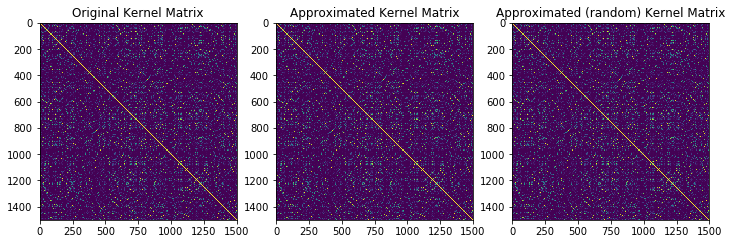

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 9))

ax[0].imshow(K)
ax[1].imshow(K_approx)
ax[2].imshow(K_rapprox)
ax[0].set_title('Original Kernel Matrix')
ax[1].set_title('Approximated Kernel Matrix')
ax[2].set_title('Approximated (random) Kernel Matrix')

plt.show()

### Nystrom Approximation of X (samples, features)

In [20]:
# Nystrom approximation of K
eps = 1e-12 # lowest error approximation

# size of K
n_samples = X.shape[0]

# chose number of components
n_components= int(np.floor(n_samples/3))
n_components = min(n_samples, n_components)    # check to make sure components are less than samples

# perform random sampling (uniform sampling without replacement)
indices = np.random.permutation(n_samples)
basis_indices = indices[:n_components]
basis = X[basis_indices]

print('Size of indices: {}'.format(indices.shape))
print('Size of basis indices: {}'.format(basis_indices.shape))
print('Size of basis: {}'.format(basis.shape))

# construct the basis kernel
basis_gamma = 1 / (2 * np.mean(pdist(basis, metric='euclidean')))
basis_kernel = rbf_kernel(basis, gamma=basis_gamma)

print('Size of basis Kernel: {}'.format(basis_kernel.shape))

# get basis vectors
U, S, V = np.linalg.svd(basis_kernel)

S = np.maximum(S, eps)

normalization = np.matmul(U / np.sqrt(S), V)

components = basis
component_indices = basis_indices

print('Size of normalization: {}'.format(normalization.shape))
print('Size of components: {}'.format(components.shape))
print('Size of component indices: {}'.format(component_indices.shape))

# transform new data

Size of indices: (1500,)
Size of basis indices: (500,)
Size of basis: (500, 3)
Size of basis Kernel: (500, 500)
Size of normalization: (500, 500)
Size of components: (500, 3)
Size of component indices: (500,)
